In [115]:
import itertools, json, logging, re, string, sys
from collections import defaultdict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from strsimpy.weighted_levenshtein import WeightedLevenshtein

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

sh = logging.StreamHandler(sys.stderr)
sh.setLevel(logging.INFO)
fmt = '%(asctime)s %(message)s'
dfmt = '%y-%m-%d  %H:%M:%S'
logging.basicConfig(handlers=(sh,), format=fmt, datefmt=dfmt, level=logging.INFO)

# Read Data

Read printer data into a DataFrame and subset it into those that already have VIAF IDs and those that don't. 

Plot total texts, texts with IDs, texts without IDs

In [89]:
printers_data_file = 'data/printers_etc.csv'
printers_df = pd.read_csv(printers_data_file)

# This is necessary because some parsedDates have two years (this needs to be fixed)
# So we just keep the first year and then turn the whole column to ints
printers_df['parsedDate'] = printers_df['parsedDate'].str[:4]
printers_df['parsedDate'] = pd.to_numeric(printers_df['parsedDate'])

viaf_exists = printers_df[~printers_df['viafId'].isna()]
viaf_needed = printers_df[printers_df['viafId'].isna()]

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (7,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Total Number of texts:  80,153
Texts with VIAF IDs:    15,927
Texts without VIAF IDs: 64,226


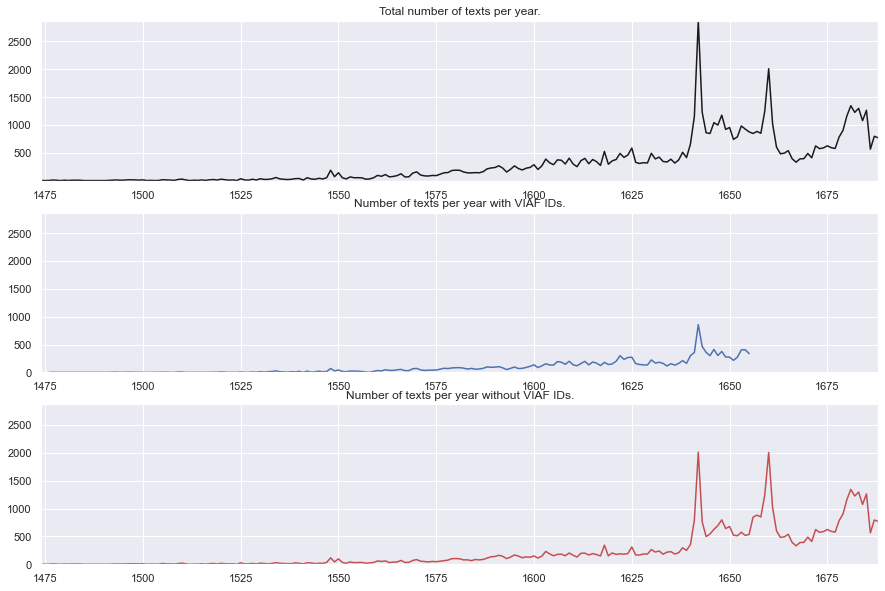

In [90]:
# Change these values to zoom in on shorter yearspans
start_year = 1400
end_year = 1750

total_counts = printers_df.groupby(['parsedDate'])['parsedDate'].count()
viaf_exists_counts = viaf_exists.groupby(['parsedDate'])['parsedDate'].count()
viaf_needed_counts = viaf_needed.groupby(['parsedDate'])['parsedDate'].count()

# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(3,1)
axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[2, 0])]

sns.lineplot(data=total_counts, x=total_counts.index, y=total_counts.values, color='k', ax=axes[0])
sns.lineplot(data=viaf_exists_counts, x=viaf_exists_counts.index, y=viaf_exists_counts.values, color='b', ax=axes[1])
sns.lineplot(data=viaf_needed_counts, x=viaf_needed_counts.index, y=viaf_needed_counts.values, color='r', ax=axes[2])

start_year = start_year if int(total_counts.index[0]) < start_year else int(total_counts.index[0])
end_year = end_year if int(total_counts.index[-1]) > end_year else int(total_counts.index[-1])
axes[0].set(xlim=(start_year, end_year), ylim=(1, max(total_counts.values)), xlabel=None, title='Total number of texts per year.')
axes[1].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year with VIAF IDs.')
axes[2].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year without VIAF IDs.')

print('Total Number of texts:  {:,}\nTexts with VIAF IDs:    {:,}\nTexts without VIAF IDs: {:,}'\
          .format(len(printers_df), len(viaf_exists), len(viaf_needed)))

### Replace viaf_needed with a small subset to speed up testing

In [91]:
viaf_needed

viaf_needed = viaf_needed[:10000]

## Some early Exploration about common misspellings into the database
These numbers may be low but remember this is of the names that have not already been asigned a identifier (i.e. half the database)

So far I compared John-Iohn, William-Wyllyam, and counted number of "me "

In [5]:
#compare john to iohn
#create a mask for john and John
john_mask = viaf_needed["name"].str.contains("John", case=False)
#count the number of times the mask evaluated to true
john_count = john_mask.sum()
#create a mask for iohn and Iohn
iohn_mask = viaf_needed["name"].str.contains("Iohn", case=False)
#count the number of times the mask evaluated to true
iohn_count = iohn_mask.sum()
print(f"Number of occurrences of 'John' or 'john': {john_count} \n Number of occurrences of 'Iohn' or 'iohn': {iohn_count}")
#compare william to wyllyam (same procedure as above)
will_mask = viaf_needed["name"].str.contains("William", case=False)
will_count = will_mask.sum()
wyyll_mask = viaf_needed["name"].str.contains("Wyllyam", case=False)
wyll_count = wyyll_mask.sum()
print(f"Number of occurrences of 'William' or 'william': {will_count} \n Number of occurrences of 'Wyllyam' or 'wyllyam': {wyll_count}")
#number of occurences of "me " at beginning of name
# Define a regular expression pattern to match "me " at the beginning of each cell. ^ = beginning of the text
pattern = r"^me "
# Count the number of times the pattern occurs in each cell of the "name" column
counts = viaf_needed["name"].str.count(pattern)
# Sum the count of pattern occurrences to get the total count
total_count = counts.sum()
# Print the total count
print("Number of occurrences of 'me ' at the beginning of each cell:", total_count)

Number of occurrences of 'John' or 'john': 4973 
 Number of occurrences of 'Iohn' or 'iohn': 1773
Number of occurrences of 'William' or 'william': 2450 
 Number of occurrences of 'Wyllyam' or 'wyllyam': 34
Number of occurrences of 'me ' at the beginning of each cell: 69


# Edit Distance Calculations

The following section uses the python module Levenshtein* to count the edit distance. 
The script works by looping through the list of names and calculating the distance between names. The distance value that is calculated is the number of edits; therefore, fewer edits is better. The number of edits is capped with the threshold variable, and changing this to a lower number will great fewer yet higher fidelity results. 

After calculating the distance the script then creates a list of three closest names that are less than 10 edits away. If there is at least one similar name passing the threshold, it is outputted at the end.

However, the metric is far from perfect. The following sections clean the data for better results.

*The Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. [Wikiapedia](https://en.wikipedia.org/wiki/Levenshtein_distance) 

##### NOTE: This computes N^2 edit distances and is time consuming

In [ ]:
#levenshtein (edit) distance
import Levenshtein

# Get a list of unique names in the "Name" column
names = viaf_needed["name"].unique()

# Create an empty dictionary to store the results
result_dict = {}

# Set the maximum number of edits allowed between the names
threshold = 10

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        # Calculate the Levenshtein distance between the two names
        distance = Levenshtein.distance(name, name2, weights=(2,2,1))
        
        # Store the distance in the distances list
        if distance < threshold:
            distances.append((name2, distance))
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")


# Improving Levenshtein

The following section improves on the process by removing "me " from the beginning of the names column and by removing all punctuation

It also reduces the total number of edits allowed (i.e. threshold) to create higher fidelity results.

In [ ]:
#levenshtein (edit) distance (without "me ")
viaf_needed["name"] = viaf_needed["name"].str.replace("^me ", "", regex=True)

#remove punctuation
punctuation = string.punctuation

viaf_needed["name"] = viaf_needed["name"].str.replace(f"[{punctuation}]", "",regex=True)

# Get a list of unique names in the "Name" column
names = viaf_needed["name"].unique()

# Create an empty dictionary to store the results
result_dict = {}

# Set the maximum number of edits allowed between the names
threshold = 4

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        # Calculate the Levenshtein distance between the two names
        distance = Levenshtein.distance(name, name2, weights=(2,2,1))
        
        # Store the distance in the distances list
        if distance < threshold:
            distances.append((name2, distance))
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")

# Name Preprocessing function

Preprocesses names to a clean (firstname, lastname) tuple. Returns None if it doesn't look like a name.

##### Note: A trick to try later. Learn the vocabulary used in all name strings and ignore frequently used words like 'active' etc
##### Note: We should also try https://spacy.io/api/entityrecognizer

In [117]:
# The name abbreviations dictionary can be passed to the name_preprocess function
with open('./data/name_abbreviations.json') as file:
    name_abbreviations = json.load(file)
    
def name_preprocess(full_name, lower_case=False, name_abbreviations={}, \
                    max_length=30, min_tokens=2, max_tokens=4):
    # Clean up name - remove 'me' and punctuation integers
    full_name = re.sub(f'^me\s*|[{string.punctuation}]|\d*', '', full_name)
    # Collapse vv to w
    full_name = re.sub('vv', 'w', full_name)
    full_name = re.sub('VV', 'W', full_name)
    if lower_case:
        full_name = full_name.lower()
    
    #ignore names that are too long
    if len(full_name) > max_length:
        logging.info(f'Too long: Ignoring: {full_name}')
        return None
    #find all strings separated by whitespace
    words = re.findall(r'\b\w+\b', full_name)
    # check if the number of words is at least 2 or over 4
    if len(words) < min_tokens:
        logging.info(f'Too few tokens: Ignoring: {full_name}')
        return None
    if len(words) > max_tokens:
        logging.info(f'Too many tokens: Ignoring: {full_name}')
        return None
    # return the first word and remaining string as a tuple
    first_name = words[0]
    if first_name in name_abbreviations:
        first_name = name_abbreviations[first_name]
    last_name = ' '.join(words[1:])
    return (first_name, last_name)

# simple function that splits name
def name_preprocess_simple(full_name):
    words = re.findall(r'\b\w+\b', full_name)
    first_name = words[0]
    last_name = ' '.join(words[1:])
    return (first_name, last_name)

## Weighted Levenshtein Distance - https://pypi.org/project/strsimpy/

First generate a substitution cost dictionary and function.

In [118]:
def substitution_cost(x, y):
    sc = substitution_cost_dict[(x,y)] if (x, y) in substitution_cost_dict else 1.0
    return sc

def substitution_cost_dict_generate(substitution_cost_dict, swapcase_weight=0.2):
    # Generate reverse pairs for the cost dictionary
    reversed_substitution_cost_dict = {}

    for (c1, c2), w in substitution_cost_dict.items():
        # (i, j) -> (j, i)
        if (c2, c1) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c2, c1)] = w
        # (i, j) -> (i, J) and (I, j)
        if (c1.swapcase(), c2) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c1.swapcase(), c2)] = w
        if (c1, c2.swapcase()) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c1, c2.swapcase())] = w
        # (a, A), (A, a) etc
        for l in string.ascii_letters:
            if (l, l.swapcase()) not in substitution_cost_dict:
                reversed_substitution_cost_dict[(l, l.swapcase())] = swapcase_weight

    substitution_cost_dict = {**substitution_cost_dict, **reversed_substitution_cost_dict}

    return substitution_cost_dict

# This needs to have both (c1, c2) and (c2, c1) pairs only if the weights are different. 
# Otherwise (c2, c1) is generated automatically below.
substitution_cost_dict = {('i', 'j'): 0.3,
                          ('u', 'v'): 0.3,
                          ('y', 'i'): 0.3,
                          ('e', 'y'):.8}

# Expand the above cost_dict by passing through the substitution_cost_dict_generate function
substitution_cost_dict = substitution_cost_dict_generate(substitution_cost_dict)

### Eliminate unlikely name pairs

We will throw out name pairs that look too different. Key goal heare is to reduce the number of name-pairs we run through the Weighted Levenshtein function. 

* We'll first generate all possible unique name pair combinations. 
* Of these, we'll only keep ones that have same or similar (i.e. i/y etc) first and last initials.

##### Note: We need to tweak this

In [120]:
# Get a list of unique names in the "Name" column. Note we compute unique twice as 
# name_preprocess is likely to resolve some names that were originally trivially different
names = list(set([name_preprocess(name, name_abbreviations=name_abbreviations) \
                  for name in viaf_needed["name"].unique() if name_preprocess(name, \
                  name_abbreviations=name_abbreviations)!=None]))

name_pairs = itertools.combinations(names, 2)
# Only keep name pairs with same or similar initials 
# -- this needs to be modified with other criteria later
# Note the substitution cost lookup here is a bit slow. 
name_pairs = [((f1, l1), (f2, l2)) for (f1, l1), (f2, l2) in name_pairs \
              if (((f1[0]==f2[0]) or (substitution_cost(f1[0], f2[0])<1.0)) and \
                  ((l1[0]==l2[0]) or (substitution_cost(l1[0], l2[0])<1.0)))]

print(f'Total number if name-pairs to compute distances on: {len(name_pairs)}')
for (f1, l1), (f2, l2) in name_pairs:
    print(f'{f"{f1} {l1}":>25} : {f"{f2} {l2}"}')

23-02-19  00:38:05 Too long: Ignoring: Caxton William approximately  or 
23-02-19  00:38:05 Too long: Ignoring: Rivers Anthony Woodville Earl of  
23-02-19  00:38:05 Too long: Ignoring: s lettou et Willes de machlinia i citate Londoniarum
23-02-19  00:38:05 Too long: Ignoring: Wilhelmum de Mechlinia impressus
23-02-19  00:38:05 Too long: Ignoring: one some tyme scole mayster of saynt Albons vppon whoos soule god haue mercy Amen And newely
23-02-19  00:38:05 Too long: Ignoring: the fron ballaunce ampc Emprinted
23-02-19  00:38:05 Too long: Ignoring: the comaundement of the reuerend faher i god
23-02-19  00:38:05 Too long: Ignoring: care and charges of IohannCarl Vnckels a booke seller
23-02-19  00:38:05 Too long: Ignoring: Berners John Bourchier Lord  or 
23-02-19  00:38:05 Too long: Ignoring: Dan Thomas Rychard monke of the sayd monaster to the iunstant desyre if ryght worshypful esquyer Mayster Robert Langdon
23-02-19  00:38:05 Too many tokens: Ignoring: the kynges moost noble grace
2

23-02-19  00:38:05 Too few tokens: Ignoring: septenium
23-02-19  00:38:05 Too many tokens: Ignoring: the heirs of W Köpfel
23-02-19  00:38:05 Too many tokens: Ignoring: the heirs of W Köpfel
23-02-19  00:38:05 Too long: Ignoring: Smyth Thomas servaunt to the Quenes most excellent Majestie
23-02-19  00:38:05 Too many tokens: Ignoring: the heirs of W Rihel
23-02-19  00:38:05 Too long: Ignoring: Robart Caly wythin the precinct of Christes Hospitall
23-02-19  00:38:05 Too long: Ignoring: Ihon Cawoode one of the prynters to the Quenes Maiestye
23-02-19  00:38:05 Too long: Ignoring: amp Iehan Cawood imprimeurs pour la Maiestè de la Roine
23-02-19  00:38:05 Too long: Ignoring: Rafe Newbery Authorised accordyng to the Quenes maiesties iniunctions In the yere of our Lorde a thousande fyue hundred amp sixty The xvi daye of Marche And
23-02-19  00:38:05 Too long: Ignoring: great S Bartelmewes beyonde Aldersgate
23-02-19  00:38:05 Too long: Ignoring: Wyllyam Martyne and ar to be solde
23-02-19  00

23-02-19  00:38:05 Too long: Ignoring: amp se vendent a sa bottique en Cornehill prez de la Bourse
23-02-19  00:38:05 Too many tokens: Ignoring: the widow of Thomas Butter
23-02-19  00:38:05 Too long: Ignoring: T Nelson ouer against the South doore of Pauls
23-02-19  00:38:05 Too many tokens: Ignoring: Thomas Scarlet ie John Wolfe
23-02-19  00:38:05 Too many tokens: Ignoring: T Este the assigné of W Byrd
23-02-19  00:38:05 Too long: Ignoring: Johannis Legatt celeberrimæ Academiæ Cantabrigiensis typographi
23-02-19  00:38:05 Too long: Ignoring: Thomas Dausonus pro Ricardo Watkins
23-02-19  00:38:05 Too long: Ignoring: the deputies of Cristopher sic Barker
23-02-19  00:38:05 Too few tokens: Ignoring: RB
23-02-19  00:38:05 Too many tokens: Ignoring: I Windet pro Richardo Watkins
23-02-19  00:38:05 Too long: Ignoring: the Vniversitie of Cambridge  And
23-02-19  00:38:05 Too long: Ignoring: Keere Pieter van den approximately approximately 
23-02-19  00:38:05 Too long: Ignoring: the Vniuersi

23-02-19  00:38:05 Too few tokens: Ignoring: EA
23-02-19  00:38:05 Too few tokens: Ignoring: WB
23-02-19  00:38:05 Too long: Ignoring: the Kings most Excellent Maiestie
23-02-19  00:38:05 Too many tokens: Ignoring: the Honourable City of London
23-02-19  00:38:05 Too long: Ignoring: the Vniuersitie of Cambridge And
23-02-19  00:38:05 Too long: Ignoring: Russell Elizabeth Cooke Hoby Lady approximately 
23-02-19  00:38:05 Too few tokens: Ignoring: London
23-02-19  00:38:05 Too long: Ignoring: Richard Field Impensis Georg Bishop
23-02-19  00:38:05 Too few tokens: Ignoring: FB
23-02-19  00:38:05 Too few tokens: Ignoring: WWhite
23-02-19  00:38:05 Too many tokens: Ignoring: the Honorable Citie of London
23-02-19  00:38:05 Too long: Ignoring: the Kings most Excellent Majestie
23-02-19  00:38:05 Too long: Ignoring: the Vniversitie of Cambridge  And
23-02-19  00:38:05 Too long: Ignoring: the Kings most excellent Majestie
23-02-19  00:38:05 Too many tokens: Ignoring: Adam Islip impensis G Bisho

23-02-19  00:38:05 Too long: Ignoring: the deputies of Christopher Barker ie B Norton
23-02-19  00:38:05 Too few tokens: Ignoring: Deputies
23-02-19  00:38:05 Too long: Ignoring: the Kings Most Excellent Maiestie
23-02-19  00:38:05 Too long: Ignoring: Bonham Nortonand Iohn Bill deputie printers
23-02-19  00:38:05 Too many tokens: Ignoring: Io Sudbury amp George Humble
23-02-19  00:38:05 Too few tokens: Ignoring: GE
23-02-19  00:38:05 Too few tokens: Ignoring: TB
23-02-19  00:38:05 Too few tokens: Ignoring: GP
23-02-19  00:38:05 Too few tokens: Ignoring: PaulsChurchyard
23-02-19  00:38:05 Too long: Ignoring: Printers to the Kings most Excellent Maiestie
23-02-19  00:38:05 Too many tokens: Ignoring: W Jones or W Stansby
23-02-19  00:38:05 Too many tokens: Ignoring: Henry Tomes ie W Jaggard
23-02-19  00:38:05 Too long: Ignoring: Passe Crispijn van de approximately 
23-02-19  00:38:05 Too long: Ignoring: Passe Magdalena van de approximately 
23-02-19  00:38:05 Too few tokens: Ignoring: HG


Total number if name-pairs to compute distances on: 19458
            Richard Ivgge : Richart Ihones
            Richard Ivgge : Rychard Iugge
            Richard Ivgge : Raph Iacson
            Richard Ivgge : Richard Iones And
            Richard Ivgge : Rychard Iohnes
            Richard Ivgge : Ralph Iackson
            Richard Ivgge : Richard Iohns
            Richard Ivgge : Richard Iones
            Richard Ivgge : Richard Iohnes
            Richard Ivgge : R Iohnes
            Richard Ivgge : Raphe Iackson
            Richard Ivgge : Richarde Iugge
            Richard Ivgge : Ralfe Iacson
            Richard Ivgge : Roger Iackson
            Richard Ivgge : Robert Iackson
            Richard Ivgge : Richard Iackson
            Richard Ivgge : Richard Ihones and
            Richard Ivgge : R Iackson
            Richard Ivgge : Raph Iackson
            Richard Ivgge : Rafe Iackson
            Richard Ivgge : Ralphe Iackson
            Richard Ivgge : Richarde Iones
            Ri

                 Io Bayly : Iohn Byddell
                 Io Bayly : Io Budge
                 Io Bayly : Iohn Bellamine ie Bellamie
                 Io Bayly : Iames Bowler
                 Io Bayly : Iohn Bartlett
                 Io Bayly : Iohn Bill
                 Io Bayly : Iohn Brambridge
                 Io Bayly : I B active
                 Io Bayly : Iohn Ballamie
                 Io Bayly : Iohn Busbie
                 Io Bayly : I Browne
                 Io Bayly : Iohn Broome
                 Io Bayly : Iohn Browne
                 Io Bayly : I Busby
                 Io Bayly : Iohn Busby
                 Io Bayly : Io Bartlet
                 Io Bayly : Iacques Besonge
                 Io Bayly : Iohan Byddell
                 Io Bayly : I Barnes
                 Io Bayly : Isaac Bing
                 Io Bayly : Iohn Bellamie
                 Io Bayly : Iohn Budgde ie Budge
                 Io Bayly : Iohn Bill deputie printers
                 Io Bayly : Iohn Barlett
 

                R Nuberie : Raufe Newberie
                R Nuberie : Ralphe Nubery assigned
                R Nuberie : Ro Nicolson
                R Nuberie : Rafe Newbery
                R Nuberie : Ralph Newberrie
                R Nuberie : Ralphe Newbery
                R Nuberie : Ralfe Newberie
                R Nuberie : Ra Newbery
                R Nuberie : Rafe Newberie
                R Nuberie : Ralphe Newberie
             George Gybbs : George Gibbs
             George Gybbs : Gibbs George active
             George Gybbs : Gascoigne George
             George Gybbs : Gilpin George
             George Gybbs : Gilby Goddred
             George Gybbs : George Gibbes
             George Gybbs : Gifford George
             Haslop Henry : H H
             Haslop Henry : Hexham Henry
             Haslop Henry : Henry Holland
             Haslop Henry : Hawkins Henry
             Haslop Henry : Henry Hooke
             Haslop Henry : his highnes
             Haslop Henry : Ha

                 J Wright : J Windet
                 J Wright : J White
                 J Wright : Jemmat William
                 J Wright : Jones William active
                 J Wright : Johan waylande
                 J Wright : John Waylande
                 J Wright : John Wright
                 J Wright : J Walley
        William Firebrand : William Ferhrand ie Ferbrand
        William Firebrand : Withers Fabian
        William Firebrand : W Ferbrand
        William Firebrand : William Fearbrand
        William Firebrand : William Ferebrand
        William Firebrand : Walker Ferdinand
           Kyffin Maurice : King Mr active
                J Tisdale : John Turke
                J Tisdale : James Thomas
                J Tisdale : Jeney Thomas
             Iohn Hodgets : Iohn Hodges
             Iohn Hodgets : Ihon Harrington
             Iohn Hodgets : Iohn Hippon
             Iohn Hodgets : Iohn Hammon
             Iohn Hodgets : I Hauiland
             Iohn Hodgets : Io

              William hyl : Walpole Henry
              William hyl : William Howe
              William hyl : William Houlmes
              William hyl : William Harford
             Abell Jeffes : A Johnson
             Abell Jeffes : Alday John
             Abell Jeffes : Alford J active
             Abell Jeffes : Abel Jeffes
             Abell Jeffes : Arderne John active
             Abell Jeffes : Arthur Johnson
             Abell Jeffes : Adamson John
                T Raynold : the Royall Exchange
                T Raynold : the Roiall Exchange
                T Raynold : Tofte Robert
                T Raynold : the RoiallExchange
                T Raynold : Tottel Richard
                T Raynold : Timothie Rider
                T Raynold : Taverner Richard
                T Raynold : typographica Richardi Field
        Fisher John Saint : Fielde John
        Fisher John Saint : Finet John Sir
        Fisher John Saint : Flasket John
        Fisher John Saint : Frampton John

              Roger Warde : R Watkins
              Roger Warde : Roger warde
              Roger Warde : Robart Walley
              Roger Warde : Reginald Woulfe
              Roger Warde : Reynolde Wolfe
              Roger Warde : Robert Wilson
              Roger Warde : Rycharde Wyer
              Roger Warde : Ram William
              Roger Warde : Roger Wood
              Roger Warde : Richarde wyer
              Roger Warde : Russell William active
              Roger Warde : Reginalde Wolfe
              Roger Warde : Ri Whittakers
              Roger Warde : Robert Walker
     Blount Edward active : Bolton Edmund
     Blount Edward active : Bunny Edmund
     Blount Edward active : Bromley Edward Sir
                J Day and : John Daye
                J Day and : Jhon Day
                J Day and : Jhon daye
                J Day and : James Dane
                J Day and : J D
                J Day and : J Danter
                J Day and : Jhon Daye
                J Da

                  W Holme : Wyllyam How
                  W Holme : William How
                  W Holme : Wylliam How
                  W Holme : William Hall
                  W Holme : William Herford
                  W Holme : William Holmes
                  W Holme : William Haw
                  W Holme : William Holme
                  W Holme : William Hill
                  W Holme : Walpole Henry
                  W Holme : William Howe
                  W Holme : William Houlmes
                  W Holme : William Harford
      the Royall Exchange : the Roiall Exchange
      the Royall Exchange : Tofte Robert
      the Royall Exchange : the RoiallExchange
      the Royall Exchange : Tottel Richard
      the Royall Exchange : Timothie Rider
      the Royall Exchange : Taverner Richard
      the Royall Exchange : typographica Richardi Field
             Garnet Henry : Georg Humble
             Garnet Henry : Grantham Henry active
             Garnet Henry : Gough Hugh activ

           Thomas Snodham : Thomas Symcocke
           Thomas Snodham : the SouthChurch
           Thomas Snodham : Thomas Snodham Assigned
           Thomas Snodham : the states of Zealande
           Thomas Snodham : Thomas Symcock
           Thomas Snodham : Toby Smyth
           Thomas Snodham : the States of Zealand
           Thomas Snodham : the States
           Thomas Snodham : the stockes
            Cutbert Burby : C Boscard
            Cutbert Burby : Christopher Barker
            Cutbert Burby : Cuthbert Burbey
            Cutbert Burby : Cutbert Burbie
            Cutbert Burby : Cuthbert Burby
            Cutbert Burby : Cristopher Barker
            Cutbert Burby : Charles Boscard
            Cutbert Burby : Cuthbert Burbie
            Cutbert Burby : C Barker
            Cutbert Burby : Cuthburt Burby
            Cutbert Burby : Cuthburt Burbie
           Ferrers George : F Groue
           Ferrers George : Francis Groue
           Ferrers George : Fenton Geoffrey Sir

Browne Thomas approximately : Bright Timothie
Browne Thomas approximately : Broke Thomas
Browne Thomas approximately : Blundeville Thomas active
Browne Thomas approximately : Beard Thomas
Browne Thomas approximately : Bry Theodor de
Browne Thomas approximately : Berthelet Thomas
            Thomas Morley : Thomas Man I
            Thomas Morley : Thomas Millington
            Thomas Morley : T Morley
            Thomas Morley : Thomas Man senior
            Thomas Morley : Thomas Man the younger
            Thomas Morley : Thomas Man
            Thomas Morley : Thomas Man the yonger
            Thomas Morley : Tyler Margaret active
            Thomas Morley : Thomas man sic
            Thomas Morley : T Millington
            Thomas Morley : T Man
            Thomas Morley : T Manne
           Walter Mantell : W Marshall
           Walter Mantell : Wyllyam Myddylton
           Walter Mantell : wyllyam Myddylton
           Walter Mantell : Walpole Michael
           Walter Mantell : W M

 Roger Dainell ie Daniell : Robert Dexter
 Roger Dainell ie Daniell : Robert de Baudous Printed
 Roger Dainell ie Daniell : Rowland David active
            Iohn Kyngston : Ihon Kingston
            Iohn Kyngston : Ihon Kingstone
            Iohn Kyngston : Iohn Kyng
            Iohn Kyngston : Iohn Kid
            Iohn Kyngston : Ioannem Keerbergium
            Iohn Kyngston : Iohn Kingstone
       the lytle Conduyte : the Litle Counduit
       the lytle Conduyte : Thomas Lawe
       the lytle Conduyte : Thomas Lawe and
       the lytle Conduyte : the litle Condite
       the lytle Conduyte : the lytle Conduit
       the lytle Conduyte : Thomas Lowns
       the lytle Conduyte : the lytle cunduite
       the lytle Conduyte : Tomson Laurence
           Porro Girolamo : Penelope George
           Porro Girolamo : Pettie George
           Porro Girolamo : Peter Geuaerts
        William Blackwall : William Barret
        William Blackwall : William Barlow
        William Blackwall : W Bart

             I Winnington : Iohn Wolf
             I Winnington : Iohn Windes
             I Winnington : Iohn Windet
             I Winnington : Iohn Woofe
             I Winnington : Iohn White
             I Winnington : Iohn Wolfe
             I Winnington : Iohn Wally
             I Winnington : Ihon Windet
             I Winnington : Ihon Waley
             I Winnington : Iohn Wailande
             I Winnington : Iohn Woolfe
             I Winnington : Iohn Wayland
             I Winnington : Iohn waley
            Roger Michell : Robert Mylburne
            Roger Michell : Ralfe Mab
            Roger Michell : Roger Madeley
            Roger Michell : R Michell
            Roger Michell : R M active
            Roger Michell : Richard Mundee
            Roger Michell : R Mabbe
            Roger Michell : Ralph Mabbe
           Clement Knight : Cle Knight
           Clement Knight : C Knight
      great S Bartelmewes : Gregorie Seaton
      great S Bartelmewes : G Shaw
      grea

          Henry Sanderson : Hugh Syngelton
          Henry Sanderson : Hewghe Singelton
          Henry Sanderson : Hugh Singleton
          Henry Sanderson : Henrie Sharpe
                H Roberts : H Rockett
                H Roberts : Henryson Robert
                H Roberts : Harrison Robert
                H Roberts : Heasse Robert
                H Roberts : Henry Rockit
                H Roberts : Hatton Richard
                H Roberts : Hakluyt Richard
             Broke Thomas : Blundeville Thomas active
             Broke Thomas : Beard Thomas
             Broke Thomas : Bry Theodor de
             Broke Thomas : Berthelet Thomas
        Doesborch Jan van : Danyel John approximately
        Doesborch Jan van : Drummond Jonas
        Doesborch Jan van : Dowland John
        Doesborch Jan van : Dyke Jeremiah
        Doesborch Jan van : Dorothy Jaggard
    Thomas Man the yonger : Tyler Margaret active
    Thomas Man the yonger : Thomas man sic
    Thomas Man the yonger : T M

                Io Busbie : I Bartlet
                Io Busbie : Iohn Buzbie
                Io Busbie : Ioseph Barnes
                 B Fisher : Beaumont Francis
                 B Fisher : Belleforest Franc ois de
                 Iohn Kid : Ioannem Keerbergium
                 Iohn Kid : Iohn Kingstone
               Iohn Badge : I Bing
               Iohn Badge : Iohannis Beale
               Iohn Badge : I Bartlet
               Iohn Badge : Iohn Buzbie
               Iohn Badge : Ioseph Barnes
       the good of others : T G active
       the good of others : Thomas Gilbert
               Iames Shaw : Iohn Smithicke
               Iames Shaw : I Standish
               Iames Shaw : Iohn Shepperde
              Veghelman S : Valentime Sims
             Walter Barre : Walter Bvrre
             Walter Barre : William Barley
             Walter Barre : W Blackwall
             Walter Barre : William Butler
             Walter Barre : William Bladen
             Walter Barre : W Bar

## Compute Weighted Levenshtein Distances

* Compute all distances between name_pairs generated above. Store result in a dict of dicts.
    * {N1: {N2:dist_N1_N2, N3:dist_N1_N3}, N2:{N1:dist_N1,N2 ...}} etc.
* Print out a sorted list of distances for each name that meet the cutoff_cost threshold.

In [125]:
# We ignore name_pairs above this cutoff cost as too dissimilar
cutoff_cost = 5

weighted_levenshtein = WeightedLevenshtein(substitution_cost_fn=substitution_cost)

# dictionaries to store the results and distances
distances = defaultdict(dict)

for (f1, l1), (f2, l2) in name_pairs:
    # NOTE: If the first name is a
    distance = weighted_levenshtein.distance(f1, f2) + weighted_levenshtein.distance(l1, l2)
    if distance <= cutoff_cost:
        distances[(f1, l1)][(f2, l2)] = distance
        distances[(f2, l2)][(f1, l1)] = distance

for f, l in sorted(distances):
    print(f'{f"{f} {l}":<20}: ', end=' ')
    closest = [f'{f2} {l2}({distances[(f, l)][(f2, l2)]})' \
               for (f2, l2), d in sorted(distances[(f, l)].items(), key=lambda x:x[1])]
    print(', '.join(closest))

A Ieffes            :  Abel Ieffs(4.0), Abell Ieffes(4.0), Abell Ieffs(5.0)
A Iohnson           :  Arthur Iohnson(5.0)
A Johnson           :  Arthur Johnson(5.0)
A L active          :  A Lacy(4.3)
A Lacy              :  A L active(4.3)
A Mathews           :  A Maunsell(5.0)
A Maunsell          :  Andrew Maunsell(5.0), A Mathews(5.0)
Abel Ieffs          :  Abell Ieffs(1.0), Abell Ieffes(2.0), A Ieffes(4.0)
Abel Jeffes         :  Abell Jeffes(1.0)
Abell Ieffes        :  Abell Ieffs(1.0), Abel Ieffs(2.0), A Ieffes(4.0)
Abell Ieffs         :  Abel Ieffs(1.0), Abell Ieffes(1.0), A Ieffes(5.0)
Abell Jeffes        :  Abel Jeffes(1.0)
Abraham Kitson      :  Abraham Kitsonne(2.0)
Abraham Kitsonne    :  Abraham Kitson(2.0)
Abraham Veale       :  Abraham Vele(1.0)
Abraham Vele        :  Abraham Veale(1.0)
Adamson John        :  Alday John(5.0)
Aggas Edward        :  Allde Edward(4.0)
Alday John          :  Allde John(2.8), Adamson John(5.0)
Alexander Lacie     :  Alexander Lacy(1.3)
Alexander Lac

Malet Francis       :  Mills Francis(3.0), Meres Francis(3.0)
Marten Anthony      :  Munday Anthony(5.0)
Martin Clarke       :  Martin Clerke(1.0), Martin Clearke(1.0)
Martin Clearke      :  Martin Clarke(1.0), Martin Clerke(1.0)
Martin Clerke       :  Martin Clarke(1.0), Martin Clearke(1.0)
Mathew Cooke        :  Matthew Cooke(1.0), M Cooke(5.0)
Mathew Law          :  Matthew Law(1.0), Mathew Lawe(1.0), Mathew Lownes(4.0), Matthew Lownes(5.0)
Mathew Lawe         :  Mathew Law(1.0), Matthew Law(2.0), Mathew Lownes(3.0), Matthew Lownes(4.0)
Mathew Lownes       :  Matthew Lownes(1.0), Mathew Lawe(3.0), Mathew Law(4.0), Matthew Law(5.0)
Mathew Selman       :  Matthew Selman(1.0)
Matthew Cooke       :  Mathew Cooke(1.0)
Matthew Law         :  Mathew Law(1.0), Mathew Lawe(2.0), Matthew Lownes(4.0), Mathew Lownes(5.0)
Matthew Lownes      :  Mathew Lownes(1.0), Matthew Law(4.0), Mathew Lawe(4.0), Mathew Law(5.0)
Matthew Lownes I Browne:  Matthew Lownes Iohn Brome(5.0)
Matthew Lownes Iohn Brom

Wood T active       :  Wood Thomas active(5.0)
Wood Thomas active  :  Wood T active(5.0)
Wright William      :  Ward William(5.0), Welby William(5.0)
Wykyn de Worde      :  Wynkyn de Worde(1.0), Wynkyn de worde(1.2), wynkyn de worde(1.4), Wynken de Worde(1.8), Wynken de worde(2.0)
Wyliyam Powell      :  Wyllyam Powell(1.0), Wylliam Powell(1.3), Willyam Powell(1.3), William Powell(1.6), Wyllyam Powel(2.0)
Wyllam Copland      :  Wyllyam Copland(1.0), Wylliam Copland(1.0), wyllyam Copland(1.2), wylliam Copland(1.2), William Copland(1.3), William Coplande(2.3), W Copland(5.0)
Wyllaym Seres       :  Wyllyam Seres(2.0), Wylliam Seres(2.0), Willyam Seres(2.3), William Seres(2.3), Wiyllyam Seres(3.0), Wyllyam Seares(3.0)
Wylliam Awen        :  Wyllyam Awen(0.3), William Awen(0.3), William Aspley(4.3)
Wylliam Bonham      :  William Butlar(4.3), Wylliam Brome(5.0)
Wylliam Brome       :  William Broome(1.3), William Barley(4.1), William Byrd(4.3), William Barret(4.3), William Barlow(4.3), William

In [77]:
# Leaving the old code here temporarily
    
    
            # Store the result in the cache
            if name2 not in distance_cache:
                distance_cache[name2] = {}
            distance_cache[name2][name] = distance
        
        # Store the distance in the distances list if it's below the threshold
        if distance < threshold:
            distances.append((name2, distance))
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")

    
# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        if name == name2:
            continue
        # check if lengths are of a distance greater than threshold. IF so can skip
        if abs(len(name)-len(name2)) > threshold:
            continue
        # Check if the result is already in the cache
        if name2 in distance_cache and name in distance_cache[name2]:
            distance = distance_cache[name2][name]
        else:
            # Calculate the Levenshtein distance between the two names
            distance = weighted_levenshtein.distance(name, name2)
            
            # Store the result in the cache
            if name2 not in distance_cache:
                distance_cache[name2] = {}
            distance_cache[name2][name] = distance
        
        # Store the distance in the distances list if it's below the threshold
        if distance < threshold:
            distances.append((name2, distance))
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 10)